In [3]:
%matplotlib inline
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TODO
* Distance
* SOM
* Compare measurements and forecasts

# Data preparation
Reading forecasts and observations

In [4]:
# forecast dimensions
N = 281
T = 60
base_dir = 'd:/GitHub/python-2-work/' # work
# base_dir = 'd:/_SRC_/ensemble-forecasting/' # home
fc_hiromb = np.loadtxt(base_dir + 'data/ensemble-forecasts/2013102012-HIROMB-S1.txt')[:N, :T+1] - 37.356
fc_baltp = np.loadtxt(base_dir + 'data/ensemble-forecasts/2013102012-BALTP-90M-GFS-S1.txt')[:N, :T+1]
fc_bsm = np.loadtxt(base_dir + 'data/ensemble-forecasts/2013102012-BSM-WOWC-HIRLAM-S1.txt')[:N, :T+1]
m = np.loadtxt(base_dir + 'data/ensemble-forecasts/2013102012-M-GI_C1NB_C1FG_SHEP_restored.txt')
# preparing measurements forecast
fc_m = np.zeros((N, T+1))
for i in range(N):
    for j in range(T+1):
        fc_m[i, j] = m[i*6+j, 2]
fc_hiromb.shape, fc_baltp.shape, fc_bsm.shape, fc_m.shape

((281, 61), (281, 61), (281, 61), (281, 61))

# Selecting peaks

In [57]:
fc_list = fc_hiromb
PEAK_LEVEL = 100
def get_peak_index(fc, guard_level, k):
    mask = fc > guard_level
    r_mask = np.concatenate(([False,], mask[:-1]))
    l_mask = np.concatenate((mask[1:], [False,]))
    idx = np.array([np.where(mask & ~r_mask)[0], np.where(mask & ~l_mask)[0]])    
    res_idx = np.empty((0, 4), int)
    for i in range(idx.shape[1]):
        res_idx = np.vstack((res_idx,
                             [k, idx[0, i], np.argmax(fc[idx[0, i]:idx[1, i] + 1]) + idx[0, i], idx[1, i]]))
    return res_idx
res_idx = np.empty((0, 4), int)
for i in range(N):
    res_idx = np.vstack((res_idx, get_peak_index(fc_list[i], PEAK_LEVEL, i)))
res_idx = np.hstack((res_idx, (res_idx[:, 2] - res_idx[:, 1] + 1).reshape((-1, 1)), 
                     (res_idx[:, 3] - res_idx[:, 2] + 1).reshape((-1, 1))))
res_idx = res_idx[(res_idx[:, 4] != 1) & (res_idx[:, 5] != 1)]  # remove one-side peaks
df = pd.DataFrame(res_idx, columns=['FC_I', 'START_IDX', 'MAX_IDX', 'STOP_IDX', 'LEFT_W', 'RIGHT_W'])
df.describe()

,FC_I,START_IDX,MAX_IDX,STOP_IDX,LEFT_W,RIGHT_W
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,171.816667,25.100000,29.416667,32.700000,5.316667,4.283333
std,82.097192,17.375904,17.362820,17.338406,2.119255,1.940572
min,27.000000,0.000000,1.000000,4.000000,2.000000,2.000000
25%,106.750000,9.750000,13.500000,16.750000,3.750000,3.000000
50%,210.500000,25.000000,29.500000,33.000000,6.000000,4.000000
75%,245.250000,40.250000,44.250000,48.250000,7.000000,5.000000
max,273.000000,54.000000,58.000000,60.000000,9.000000,9.000000


(-8, 8)

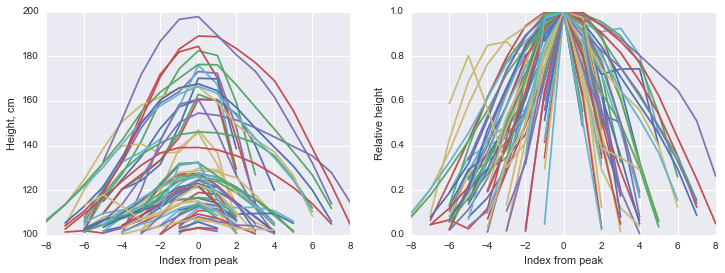

In [58]:
FC_N, FC_W, FC_MAX_POS = res_idx.shape[0], max(res_idx[:, 4]) + max(res_idx[:, 5]) - 1, max(res_idx[:, 4]) - 1
plt.figure(figsize=(12, 4))
plt.subplot(121)
peaks = np.full((FC_N, FC_W), np.NaN)
for i in range(FC_N):
    start_idx = FC_MAX_POS - (res_idx[i, 2] - res_idx[i, 1])
    for k in range(res_idx[i, 1], res_idx[i, 3] + 1):
        peaks[i, start_idx + k - res_idx[i, 1]] = fc_list[res_idx[i, 0], k]
    plt.plot(np.arange(FC_W) - FC_MAX_POS, peaks[i])
plt.xlabel('Index from peak')
plt.ylabel('Height, cm')
plt.xlim((-FC_MAX_POS, FC_W - FC_MAX_POS - 1))
plt.subplot(122)

for i in range(FC_N):
    plt.plot(np.arange(FC_W) - FC_MAX_POS, (peaks[i] - PEAK_LEVEL) / (np.nanmax(peaks[i]) - PEAK_LEVEL))
plt.xlabel('Index from peak')
plt.ylabel('Relative height')
plt.xlim((-FC_MAX_POS, FC_W - FC_MAX_POS - 1))

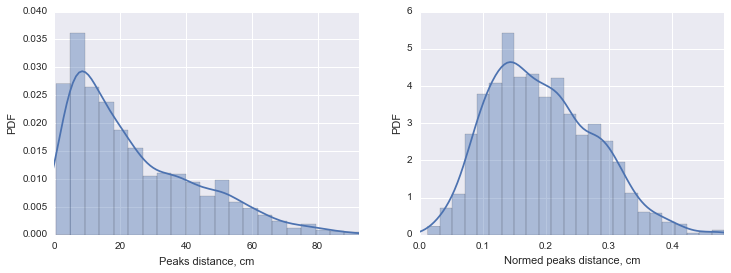

In [75]:
def dist_peak(fc_p1, fc_p2):
    return np.nanmean(np.abs(fc_p1 - fc_p2))
norm_peaks = [(peaks[i] - PEAK_LEVEL) / (np.nanmax(peaks[i]) - PEAK_LEVEL) for i in range(FC_N)]
dist_list = np.empty((0, 2), dtype=float)
for i in range(FC_N):
    for j in range(i + 1, FC_N):
        dist_list = np.vstack((dist_list, 
                              [dist_peak(peaks[i], peaks[j]), dist_peak(norm_peaks[i], norm_peaks[j])]))
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.distplot(dist_list[:, 0])
plt.xlim((0, max(dist_list[:, 0])))
plt.xlabel('Peaks distance, cm')
plt.ylabel('PDF')
plt.subplot(122)
sns.distplot(dist_list[:, 1])
plt.xlim((0, max(dist_list[:, 1])))
plt.xlabel('Normed peaks distance, cm')
plt.ylabel('PDF')

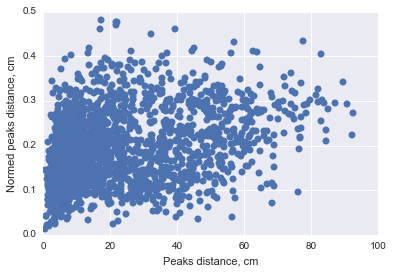

In [76]:
plt.plot(dist_list[:, 0], dist_list[:, 1], 'o')
plt.xlabel('Peaks distance, cm')
plt.ylabel('Normed peaks distance, cm')

# SOM application